In [1]:
import pandas as pd
import lightgbm as ltb
import numpy as np
import re


from scipy.stats import linregress
import scipy.linalg

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import PCA
from sklearn.kernel_ridge import KernelRidge

from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from sklearn import preprocessing

import joblib

import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')


%matplotlib inline
%config InlineBackend.figure_format = 'svg'


import warnings
warnings.simplefilter('ignore')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 5



In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_seq_items', 1000)

In [3]:
# dir_path = 'C:/Users/Edward/Documents/Appleolga/Final_pro/model2/'
dir_path = 'C:/Users/Пользователь/Desktop/BDL/Final_projects/model2/'

In [ ]:
#READING INITIAL TRAIN DATA
data_traff_train = pd.read_sas(dir_path +'train/hash_school_dpi_model_traff.sas7bdat')
data_train = pd.read_sas(dir_path + 'train/hash_school_dpi_model_fe.sas7bdat')

#READING INITIAL TEST DATA
data_traff_test = pd.read_sas(dir_path + 'test/hash_school_dpi_model_traff_test.sas7bdat')
data_test = pd.read_sas(dir_path + 'test/hash_school_dpi_model_fe_test.sas7bdat')
data_test2 = pd.read_sas(dir_path + 'test/hash_school_dpi_model_test.sas7bdat')

In [ ]:
# #DUPLICATES CLEANING AND MERGING INITIAL DATA FILES

print(data_train.shape)
print(data_traff_train.shape)
data_traff_train = data_traff_train.drop_duplicates()
data_train = data_train.drop_duplicates()
print(data_train.shape)
print(data_traff_train.shape)

data_train = data_train.merge(data_traff_train, on = 'abon_id')
del data_traff_train

print(data_test.shape)
print(data_test2.shape)
print(data_traff_test.shape)
data_test = data_test.drop_duplicates()
data_test2 = data_test2.drop_duplicates()
data_traff_test = data_traff_test.drop_duplicates()
print(data_test.shape)
print(data_test2.shape)
print(data_traff_test.shape)

data_test = data_test.merge(data_test2, on = 'abon_id').merge(data_traff_test, on = 'abon_id')
del data_test2
del data_traff_test

data_train = data_train.astype('float32')
data_test = data_test.astype('float32')




In [4]:
# # # WRITING MERGED TRAIN AND TEST DATA TO PARQUET
# # data_train.to_parquet((dir_path + 'train/data_train.parquet.gzip'),compression='gzip')
# # data_test.to_parquet((dir_path + 'test/data_test.parquet.gzip'),compression='gzip')

# # # READING INITIAL MERGED TRAIN AND TEST DATA FROM PARQUET
data_train = pd.read_parquet(dir_path + 'train/data_train.parquet.gzip')
data_test = pd.read_parquet(dir_path + 'test/data_test.parquet.gzip')

In [5]:
#CHECKING TRAFFIC VARIANCE

traffic_cols = ['traff_m5', 'traff_m4', 'traff_m3','traff_m2','traff_m1']

traff_var = pd.DataFrame(data = data_train[traffic_cols].var(), columns = ['traff_var'])

In [11]:
traff_var.style.format("{:.10}")

,traff_var
traff_m5,99.08881378
traff_m4,79435032.0
traff_m3,127.7479172
traff_m2,125.2335205
traff_m1,143.3793793


In [12]:
traffic_df_train = data_train[traffic_cols]
traffic_df_test = data_test[traffic_cols]

In [20]:
traffic_df_train.describe()

,traff_m5,traff_m4,traff_m3,traff_m2,traff_m1
count,250017.000000,2.500170e+05,250017.000000,250017.000000,250017.000000
mean,4.606479,2.306247e+01,5.675734,5.794854,5.936551
std,9.954336,8.912633e+03,11.302563,11.190779,11.974113
min,0.000000,0.000000e+00,0.000000,0.004883,0.000000
25%,0.040245,1.183636e-01,0.188417,0.324519,0.215108
50%,0.990819,1.235726e+00,1.408146,1.584272,1.473195
75%,4.329662,5.041220e+00,5.450376,5.612601,5.594456
max,1025.197510,4.456472e+06,436.159088,277.037262,640.266663


In [107]:
traffic_df_train.sort_values(by = 'traff_m4', ascending = False)

,traff_m5,traff_m4,traff_m3,traff_m2,traff_m1
index,,,,,
219252,19.389360,4.456472e+06,12.937638,22.850140,5.037920
217018,32.776627,2.341316e+02,323.528503,7.150309,57.112225
225292,203.641739,1.974701e+02,142.643738,181.878891,112.523209
115912,147.485641,1.974000e+02,1.870279,0.976280,1.645507
209639,78.837807,1.673304e+02,136.827057,88.402878,0.000019
...,...,...,...,...,...
214277,0.000000,0.000000e+00,0.000000,0.194597,0.000000
230279,0.000024,0.000000e+00,0.000000,0.103316,0.000613
73380,0.000000,0.000000e+00,0.002129,0.019230,0.005706


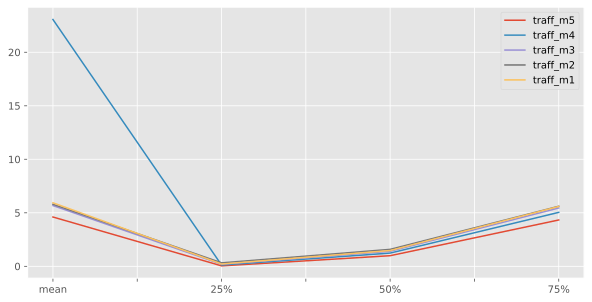

In [108]:
traffic_df_train.describe().loc[['mean','25%', '50%', '75%']].plot()

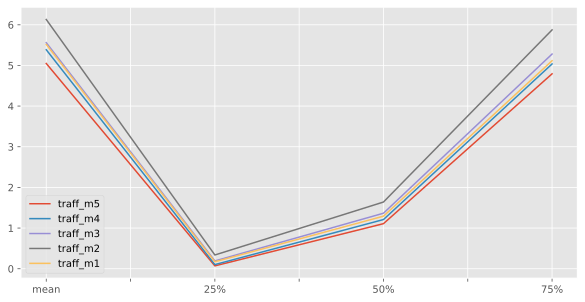

In [25]:
traffic_df_test.describe().loc[['mean','25%', '50%', '75%']].plot()

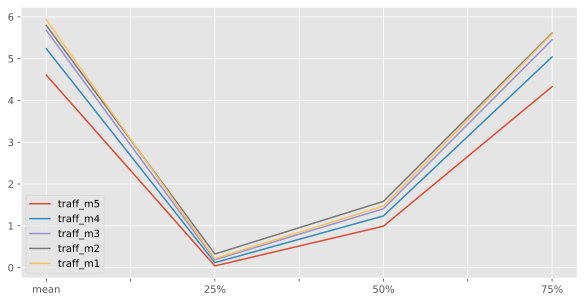

In [109]:
traffic_df_train.drop(219252).describe().loc[['mean','25%', '50%', '75%']].plot()

In [110]:
traffic_df_train.drop(219252).describe()

,traff_m5,traff_m4,traff_m3,traff_m2,traff_m1
count,250016.000000,250016.000000,250016.000000,250016.000000,250016.000000
mean,4.606420,5.238247,5.675705,5.794785,5.936554
std,9.954314,10.567046,11.302574,11.190750,11.974136
min,0.000000,0.000000,0.000000,0.004883,0.000000
25%,0.040243,0.118362,0.188416,0.324515,0.215106
50%,0.990813,1.235701,1.408129,1.584247,1.473194
75%,4.329613,5.041162,5.450338,5.612582,5.594473
max,1025.197510,234.131577,436.159088,277.037262,640.266663


In [195]:
data_train = data_train.drop(219252)
print(data_train.shape)
del traff_var

(250016, 914)


In [113]:
def mark_outliers(df, outlier_coeff = 1.5): 
    
    outliers_mask = df.copy()
    counter = 1
    for col in df.columns:
        
        p75, p25 = df[col].quantile(0.75), df[col].quantile(0.25)
        IQR_col = p75 - p25
        upper, lower = p75 + outlier_coeff*IQR_col, p25 - outlier_coeff*IQR_col
        outliers_mask[col] = df[col].apply(lambda x: True if(x > upper or x < lower) else False)
        
        if (counter%100 == 0):
            print(counter)
        counter += 1
        
    return outliers_mask  

In [114]:
#FUNCTION TO FIND CATEGORICAL COLUMNS

def find_cat_cols (df):
    
    cat_cols_list = pd.DataFrame(columns = ['col_name', 'if_cat'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        if (np.array_equal(value_count_info.index, [1,0]) or np.array_equal(value_count_info.index,[0,1])):
            if_cat = 1 
        else: 
            if_cat = 0
            
        cat_cols_list = cat_cols_list.append({'col_name': col, 'if_cat' : if_cat}, ignore_index=True)
        
    return cat_cols_list


In [116]:
# # CALCULATION OF TRAFFIC VARIANCE AND TRAFFIC COLS LIN.REGR. SLOPE FOR EACH OBSERVATION

data_train = data_train.assign(var = data_train[traffic_cols].apply(lambda x: x.var(), axis=1))
data_train = data_train.assign(var_quant = pd.qcut(data_train['var'], 10,labels = False))

data_test = data_test.assign(var = data_test[traffic_cols].apply(lambda x: x.var(), axis=1))
data_test = data_test.assign(var_quant = pd.qcut(data_test['var'], 10,labels = False))

enum = np.arange(1, len(traffic_cols)+1, 1)

data_train = data_train.assign(slope_traff = data_train.apply(lambda x: linregress(enum, x[traffic_cols]).slope, axis=1))

data_test = data_test.assign(slope_traff = data_test.apply(lambda x: linregress(enum, x[traffic_cols]).slope, axis=1))


In [168]:
data_train['slope_traff'].describe()

count    250016.000000
mean          0.321772
std           2.401774
min        -204.473556
25%          -0.147239
50%           0.018032
75%           0.404612
max         155.112234
Name: slope_traff, dtype: float64

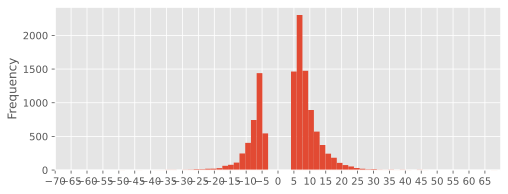

In [171]:
from scipy import stats

data_train['slope_traff'][np.abs(scipy.stats.zscore(data_train['slope_traff'])) >= 2].\
                    plot.hist(bins = 200, 
                              xlim = (-70,70), 
                              xticks = range(-70, 70, 5), 
                              figsize = (8,3))


In [167]:
data_train[(data_train['slope_traff'] > 5) &(data_train['slope_traff'] < 7)][traffic_cols].head()

,traff_m5,traff_m4,traff_m3,traff_m2,traff_m1
index,,,,,
248,30.270428,0.220626,10.543380,27.633633,46.057266
374,6.739315,9.042696,7.745949,5.876669,34.891567
494,5.016198,1.487608,3.133807,4.248379,30.145384
721,70.454506,89.741615,85.218987,96.586166,98.344543
1021,0.430560,5.296873,20.233595,26.237173,15.690711


In [200]:

X_train_full = data_train[traffic_cols + ['slope_traff']]

y_train_full = data_train['target']

X_test_full = data_test[traffic_cols + ['slope_traff']]

y_test_full = data_test['target']


slr = LinearRegression(normalize=True)

slr.fit(X_train_full, y_train_full)

y_train_pred = slr.predict(X_train_full)
y_test_pred = slr.predict(X_test_full)

print()
print('Train set results')
print()
print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred)))



Train set results

RMSE train: 8.549590, test: 8.863615
R^2 train: 0.481580, test: 0.419794


In [201]:
model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)


model.fit(X_train_full,y_train_full)

y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)


print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred)))

RMSE train: 8.124836, test: 8.726265
R^2 train: 0.531812, test: 0.437636


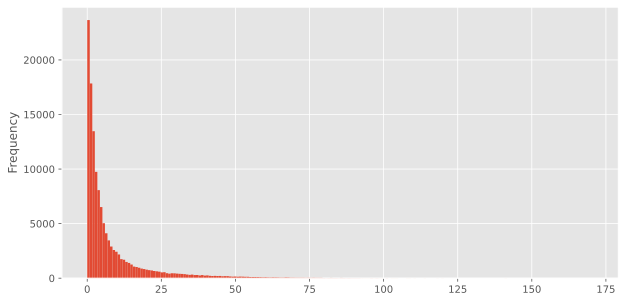

In [188]:
data_test[data_test['target'] >= 1]['traff_m1'].plot.hist(bins = 200)

In [202]:
# # WRITING TRAIN AND TEST DATA WITH VARIANCE, QUANTILES AND SLOPE TO PARQUET

data_train.to_parquet((dir_path + 'train/data_train_with_var.parquet.gzip'),compression='gzip')
data_test.to_parquet((dir_path + 'test/data_test_with_var.parquet.gzip'),compression='gzip')


In [203]:
# # READING TRAIN AND TEST DATA WITH VARIANCE QUANTILES AND SLOPE FROM PARQUET

data_train = pd.read_parquet(dir_path + 'train/data_train_with_var.parquet.gzip')
data_test = pd.read_parquet(dir_path + 'test/data_test_with_var.parquet.gzip')


In [10]:
cat_num_col_list = find_cat_cols(data_train)
cat_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 1]['col_name'].values)
num_col_list = list(cat_num_col_list[cat_num_col_list['if_cat'] == 0]['col_name'].values)
print(len(cat_col_list))
print(len(num_col_list))

32
879


In [ ]:
data_train_num = data_train[num_col_list]
data_train_num_outliers_mask = mark_outliers(data_train_num)

In [ ]:
# # READING TRAIN AND TEST DATA NUMERICAL FEAUTURES ONLY WITH VARIANCE QUANTILES AND SLOPE FROM PARQUET

data_train_num = pd.read_parquet(dir_path + 'model2_parquet/data_train_num.parquet.gzip')
data_test_num = pd.read_parquet(dir_path + 'model2_parquet/data_test_num.parquet.gzip')

In [ ]:
# FUNCTION TO MARK UNIVALUE COLUMNS, OUTLIERS, MISSING VALUES

def df_info (df, outliers_mask_df):
    
    df_info = pd.DataFrame(columns=['col', '%of_fr_univalue', '%of_unfr_univalue','freq_value', '%outliers', '%nans'])
    
    df_length = df.shape[0]
    
    for col in df.columns:
        
        value_count_info = df[col].value_counts().sort_values(ascending = False)
        
        freq_value = value_count_info.index[0]
        freq_value_count = value_count_info.iloc[0]/df_length
        #print(freq_value_count)
        try:
            unfreq_value_count = value_count_info.iloc[1]/df_length
        except:
            unfreq_value_count = np.nan
        #print(unfreq_value_count)
        perc_outl = outliers_mask_df[col].sum()/df_length
        perc_nans = df[col].isnull().sum()/df_length
        
        #print(freq_count)
        df_info = df_info.append({'col': col, 
                                  '%of_fr_univalue': freq_value_count,
                                  '%of_unfr_univalue': unfreq_value_count,
                                  '%outliers': perc_outl,
                                  '%nans': perc_nans,
                                  'freq_value': freq_value}, 
                                 ignore_index=True)
        
    return df_info.sort_values(by = ['%of_fr_univalue', '%outliers','%nans'], ascending=False) 

In [ ]:
data_train_num_info = df_info(data_train_num, data_train_num_outliers_mask)
del data_train_num_outliers_mask

In [ ]:
data_train_num_corr = data_train_num.corr()

In [11]:
# # WRITING AND READING DATA_TRAIN_INFO DF TO PARQUET

# # data_train_num_info.to_parquet((dir_path + 'data_train_num_info.parquet.gzip'),compression='gzip')

data_train_num_info = pd.read_parquet(dir_path +'data_train_num_info.parquet.gzip')


In [12]:
# # WRITING AND READING DATA_TRAIN TARGET CORRELATION DF TO PARQUET

# # data_train_num_corr.to_parquet((dir_path + 'data_train_num_corr.parquet.gzip'),compression='gzip')

data_train_num_corr = pd.read_parquet(dir_path +'data_train_num_corr.parquet.gzip')


In [ ]:
# ADDING TARGET CORR TO THE INFO DF
data_train_num_info = data_train_num_info.merge(data_train_num_corr['target'], left_on='col', right_index=True)

In [ ]:
del data_train_num_corr

In [ ]:
# HIGHLIGHT DESIRED PERCENTILE IN A SERIES

def highlight_perc(s, q):
    
    is_max = s >= s.quantile(q)
    
    return ['background-color: salmon' if v else '' for v in is_max]

In [ ]:
#PRINTING INFO DF WITH CONDITIONAL FORMATTING
data_train_num_info_style = data_train_num_info.sort_values(by = '%nans', 
                                                            ascending=False).\
                                                style.apply(highlight_perc,
                                                            subset=['%outliers', '%nans'],
                                                            **{'q': 0.75}).\
                                                format({'%of_fr_univalue': "{:.2%}",
                                                        '%of_unfr_univalue': "{:.2%}",
                                                        '%outliers': "{:.2%}",
                                                        '%nans': "{:.2%}",
                                                        'target': "{:.2f}"})
data_train_num_info_style

In [ ]:
print('low target corr features number:')
print(data_train_num_info[data_train_num_info['target'].abs() < 0.2].shape[0])


#PRINTING INFO DF FOR LOW TARGET CORR FEATURES WITH CONDITIONAL FORMATTING

data_train_num_info_style = data_train_num_info[data_train_num_info['target'].abs() < 0.2].\
                            sort_values(by = 'target', ascending=False).\
                            style.apply(highlight_perc,
                                        subset=['%outliers', '%nans'],
                                        **{'q': 0.75}).\
                                        format({'%of_fr_univalue': "{:.2%}",
                                                '%of_unfr_univalue': "{:.2%}",
                                                '%outliers': "{:.2%}",
                                                '%nans': "{:.2%}",
                                                'target': "{:.2f}"})
data_train_num_info_style

In [ ]:
print('high target corr features number:')
print(data_train_num_info[data_train_num_info['target'].abs() >= 0.2].shape[0])

#PRINTING INFO DF FOR HIGH TARGET CORR FEATURES WITH CONDITIONAL FORMATTING

data_train_num_info_style = data_train_num_info[data_train_num_info['target'].abs() >= 0.2].\
                            sort_values(by = '%nans', ascending=False).\
                            style.apply(highlight_perc,
                                        subset=['%outliers', '%nans'],
                                        **{'q': 0.75}).\
                                        format({'%of_fr_univalue': "{:.2%}",
                                                '%of_unfr_univalue': "{:.2%}",
                                                '%outliers': "{:.2%}",
                                                '%nans': "{:.2%}",
                                                'target': "{:.2f}"})
data_train_num_info_style

In [ ]:
#CHOOSING THE FEATURES WITH AT LEAST 0.2 CORRELATION COEFF WITH THE TARGET
# AND LESS THAN 60% OF MISSINGS

num_cols_to_use = data_train_num_info[(data_train_num_info['target'].abs() >= 0.2) &\
                                      (data_train_num_info['target'].abs() < 1) &\
                                      (data_train_num_info['%nans'] < 0.6)]['col'].to_list()
len(num_cols_to_use)

In [ ]:
# MERGING INFO DF WITH FEAUTURES DESCRIPTION AND CHOOSING MAX TARGET CORRELATED STAT METRIC FEAUTURES
data_descr = pd.read_csv((dir_path + 'data_descr.csv'), names=['feature', 'descr'])

data_train_num_info = pd.merge(data_train_num_info, data_descr, how='left', left_on='col', right_on='feature')
data_train_num_info.loc[data_train_num_info['descr'].isna(), 
                        'descr'] = data_train_num_info.loc[data_train_num_info['descr'].isna(), 'col']

data_train_num_info = data_train_num_info.assign(feature_clear = data_train_num_info['descr'])

expression = ' - стат.метрика'
escaped_expression = re.escape(expression)

data_train_num_info['feature_clear'] = data_train_num_info.feature_clear.apply(lambda x: re.sub(\
                                                                               escaped_expression, '', str(x)))

data_train_num_info = data_train_num_info.drop('feature', axis =1)

In [ ]:
num_cols_to_use = list(data_train_num_info.loc[data_train_num_info['col'].isin(num_cols_to_use)].\
                                       groupby('feature_clear')['col'].max('target').values)

len(num_cols_to_use)

In [ ]:
data_test_num = data_test[num_col_list]

data_train_num_filtered = data_train_num[num_cols_to_use + ['target']]
data_test_num_filtered = data_test_num[num_cols_to_use + ['target']]


print(data_train_num_filtered.shape)
print(data_test_num_filtered.shape)

In [ ]:
#FILTERING CATEGORICAL COLUMNS INTO SEPARATE DF 

data_train_cat = data_train[cat_col_list]

data_test_cat = data_test[cat_col_list]

In [ ]:
#FILTERING COLUMNS WITH BIGGEST TRAFFIC VAR INTO SEPARATE DF 

big_var_df_train = data_train_num_filtered[data_train_num_filtered['var_quant'] >= 8]
big_var_df_test = data_test_num_filtered[data_test_num_filtered['var_quant'] >= 8]

big_var_df_train = big_var_df_train.merge(data_train_cat, how  = 'left', left_index = True, right_index = True)
big_var_df_test = big_var_df_test.merge(data_test_cat, how  = 'left', left_index = True, right_index = True)


In [ ]:
#FILTERING COLUMNS WITH BIGGEST TRAFFIC VAR INTO SEPARATE DF 

small_var_df_train = data_train_num_filtered[data_train_num_filtered['var_quant'] < 8]
small_var_df_test = data_test_num_filtered[data_test_num_filtered['var_quant'] < 8]

small_var_df_train = small_var_df_train.merge(data_train_cat, how  = 'left', left_index = True, right_index = True)
small_var_df_test = small_var_df_test.merge(data_test_cat, how  = 'left', left_index = True, right_index = True)

In [ ]:
# VISUALZING TARGET DIFFERENCE RATE FOR CATEGORICAL COLUMNS

target_by_cat_cols = pd.DataFrame(index=cat_col_list, 
                                  columns=['0_bv', '1_bv', '1_to_0_rate_bv','0_sv', '1_sv', '1_to_0_rate_sv'])

for col in cat_col_list:
    temp = big_var_df_train.pivot_table(columns=col,values='target', aggfunc='median').fillna(0).applymap(float)
#     print(temp)
#     print(temp.values[0][1])
    target_by_cat_cols.loc[col]['0_bv'] = temp[0].values[0]
    try:
        target_by_cat_cols.loc[col]['1_bv'] = temp[1].values[0]
        target_by_cat_cols.loc[col]['1_to_0_rate_bv'] = temp[1].values[0]/temp[0].values[0]
    except:
        target_by_cat_cols.loc[col]['1_bv'] = np.nan
        target_by_cat_cols.loc[col]['1_to_0_rate_bv'] = np.nan
        
    temp = small_var_df_train.pivot_table(columns=col,values='target', aggfunc='median').fillna(0).applymap(float)
#     print(temp)
#     print(temp.values[0][1])
    target_by_cat_cols.loc[col]['0_sv'] = temp[0].values[0]
    try:
        target_by_cat_cols.loc[col]['1_sv'] = temp[1].values[0]
        target_by_cat_cols.loc[col]['1_to_0_rate_sv'] = temp[1].values[0]/temp[0].values[0]
    except:
        target_by_cat_cols.loc[col]['1_sv'] = np.nan
        target_by_cat_cols.loc[col]['1_to_0_rate_sv'] = np.nan


ax1 = target_by_cat_cols.sort_index().loc[:, ['0_bv', '1_bv']].plot(kind = 'bar',
                                                                       figsize = (10,5),
                                                                       rot = 90,
                                                                       sharex = True)


ax1 = target_by_cat_cols.sort_index()['1_to_0_rate_bv'].plot(secondary_y=True,
                                                                colormap = 'ocean',
                                                                rot = 90, 
                                                                legend = True,
                                                                sharex = True);

ax1.set_title('big_var')
    
ax2 = target_by_cat_cols.sort_index().loc[:, ['0_sv', '1_sv']].plot(kind = 'bar',
                                                                    figsize = (10,5),
                                                                    rot = 90,
                                                                    sharex = True);

ax2 = target_by_cat_cols.sort_index()['1_to_0_rate_sv'].plot(secondary_y=True,
                                                             colormap = 'ocean',
                                                             rot = 90,
                                                             legend = True,
                                                             sharex = True);

ax2.set_title('small_var')

In [ ]:
# from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans

X_train_big_var = big_var_df_train.fillna(0)

plot_n_clusters = 20
sse = []
for k in range(1, plot_n_clusters+1):
    
        kmeans_batch = MiniBatchKMeans(n_clusters=k, 
                 init='k-means++', 
                 n_init=10, 
                 max_iter=300, 
                 random_state=1)
        
        kmeans_batch.fit(X_train_big_var)
        sse.append(kmeans_batch.inertia_)
        
plt.style.use("fivethirtyeight")
plt.plot(range(1, plot_n_clusters+1), sse)
plt.xticks(range(1, plot_n_clusters+1))
plt.xlabel("Number of Clusters")
plt.ylabel("Sum of squared error")
plt.show()

In [ ]:
from sklearn.cluster import MiniBatchKMeans

X_train_big_var = big_var_df_train.fillna(0).astype('float32')
X_test_big_var = big_var_df_test.fillna(0).astype('float32')

kmeans_batch = MiniBatchKMeans(n_clusters=4, 
            init='k-means++', 
            n_init=10,
            max_iter=300, 
            tol=1e-04,
            random_state=1)


y_kmeans_batch_train = kmeans_batch.fit_predict(X_train_big_var)

y_kmeans_batch_test = kmeans_batch.predict(X_test_big_var)


big_var_df_train = big_var_df_train.assign(cluster = y_kmeans_batch_train)

big_var_df_test = big_var_df_test.assign(cluster = y_kmeans_batch_test)

In [ ]:
# CHECKING MULTICOLLENEARITY IN DATA

def highlight_corr_06_plus(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_high = s >= 0.6
    return ['background-color: red' if v else '' for v in is_high]

collinear_cols_style = data_train_num_corr.loc[num_cols_to_use, num_cols_to_use].\
                                           style.apply(highlight_corr_06_plus).format("{:.2%}")


collinear_cols_style

In [ ]:
data_train_num_corr.loc[num_cols_to_use, num_cols_to_use]['dpi_duration'].sort_values()

In [ ]:
data_train_num_corr.loc[num_cols_to_use, num_cols_to_use]['MV_ARPU'].sort_values()

In [ ]:
totals_for_pca = ['MV_ARPU', 'MV_ap_4G_d', 'MV_AP_total','all_clc_std_mnt3', 'clc_no_vas_roam_std_mnt3']
dpi_for_pca = ['dpi_duration', 'dpi_upload', 'dpi_download', 'dpi_events']

In [ ]:
traffic_cols.sort()
traffic_cols_plus_target = ['traff_m5', 'traff_m3','traff_m2','traff_m1', 'target']
traffic_cols_plus_target.sort()

In [ ]:
# DIMETIONALITY REDUCTION BY PCA FOR MULTICOLLINEAR COLUMNS

data_train_num_filtered = data_train_num_filtered.fillna(0)
data_test_num_filtered = data_test_num_filtered.fillna(0)


In [ ]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train_num_filtered[totals_for_pca])
X_test_std = sc_x_traf.fit_transform(data_test_num_filtered[totals_for_pca])

pca_train = PCA(random_state=3)
pca_test = PCA(random_state=3)

X_train_pca_totals = pca_train.fit_transform(X_train_std)
X_test_pca_totals = pca_test.fit_transform(X_train_std)

pd.DataFrame(pca_train.explained_variance_ratio_).style.format("{:.2%}")


In [ ]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train_num_filtered[dpi_for_pca])
X_test_std = sc_x_traf.fit_transform(data_test_num_filtered[dpi_for_pca])

pca_train = PCA(random_state=3)
pca_test = PCA(random_state=3)

X_train_pca_dpi = pca_train.fit_transform(X_train_std)
X_test_pca_dpi = pca_test.fit_transform(X_train_std)

pd.DataFrame(pca_train.explained_variance_ratio_).style.format("{:.2%}")

In [ ]:
sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train_num_filtered[totals_for_pca])
X_test_std = sc_x_traf.fit_transform(data_test_num_filtered[totals_for_pca])

pca_train = PCA(n_components = 1, random_state=3)
pca_test = PCA(n_components = 1, random_state=3)

X_train_pca_totals = pca_train.fit_transform(X_train_std)
X_test_pca_totals = pca_test.fit_transform(X_test_std)



sc_x_traf = StandardScaler()

X_train_std = sc_x_traf.fit_transform(data_train_num_filtered[dpi_for_pca])
X_test_std = sc_x_traf.fit_transform(data_test_num_filtered[dpi_for_pca])

pca_train = PCA(n_components = 2, random_state=3)
pca_test = PCA(n_components = 2, random_state=3)

X_train_pca_dpi = pca_train.fit_transform(X_train_std)
X_test_pca_dpi = pca_test.fit_transform(X_test_std)


del(X_train_std, X_test_std)

In [ ]:
del data_test_num, data_train_num, data_train_cat, data_test_cat

In [ ]:
# PREPARING DATA FOR MODELS

data_train_model = pd.read_parquet(dir_path + 'train/data_train.parquet.gzip').fillna(0)


# data_train_model = data_train_num_filtered.drop(totals_for_pca, axis=1).fillna(0)
# data_train_model = data_train_model.drop(dpi_for_pca, axis=1)
# data_train_model = data_train_model.assign(pca1=X_train_pca_totals[:, 0],
#                                            pca2=X_train_pca_dpi[:, 0],
#                                            pca3=X_train_pca_dpi[:, 1])

# data_train_model_varQ90 = data_train_model[data_train_model['var_quant'] >= 8]
# data_train_model_varQ90 = data_train_model_varQ90.merge(big_var_df_train['cluster'], how='left',
#                                                        left_index = True, right_index = True)

# data_train_model_full = data_train_model
# data_train_model = data_train_model[~data_train_model['var_quant'].isin([8,9])]

# data_train_model_varQ90 = data_train_model_varQ90.fillna(0)

In [ ]:
data_test_model = pd.read_parquet(dir_path + 'test/data_test.parquet.gzip').fillna(0)

# data_test_model = data_test_num_filtered.drop(totals_for_pca, axis=1).fillna(0)
# data_test_model = data_test_model.drop(dpi_for_pca, axis=1)
# data_test_model = data_test_model.assign(pca1=X_test_pca_totals[:, 0],
#                                          pca2=X_test_pca_dpi[:, 0],
#                                          pca3=X_test_pca_dpi[:, 1])

# data_test_model_varQ90 = data_test_model[data_test_model['var_quant'] >= 8]
# data_test_model_varQ90 = data_test_model_varQ90.merge(big_var_df_train['cluster'], how='left',
#                                                       left_index = True, right_index = True)

# data_test_model_full = data_test_model
# data_test_model = data_test_model[~data_test_model['var_quant'].isin([8,9])]

# data_test_model_varQ90 = data_test_model_varQ90.fillna(0)

In [ ]:
data_train_model.columns

In [ ]:
def df_normalization(df, cols_to_exclude = []):
    
    
    cols_to_use = list(df.columns)
   
    for col in cols_to_exclude:
        cols_to_use.remove(col)
        
    df_norm = df.copy()
    
    for column in cols_to_use: 
        df_norm[column] = (df_norm[column] - df_norm[column].min()) /(df_norm[column].max() - df_norm[column].min()) 

    return df_norm

In [ ]:
X, y = data_train_model.loc[:, data_train_model.columns != 'target'], data_train_model.target

# X = df_normalization(X, ['var_quant'])

X = df_normalization(X, [])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state = 17)

X_full, y_full = data_test_model_full.loc[:, data_test_model_full.columns != 'target'], data_test_model_full.target

X_full = df_normalization(X_full, ['var_quant'])

X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(X_full, y_full, test_size=0.30, random_state = 17)

X_varQ90 = data_train_model_varQ90.loc[:, data_train_model_varQ90.columns != 'target']
y_varQ90 = data_train_model_varQ90.target

X_varQ90 = df_normalization(X_varQ90, ['var_quant'])

X_train_varQ90, X_test_varQ90, y_train_varQ90, y_test_varQ90 = train_test_split(X_varQ90, y_varQ90, 
                                                                                test_size=0.30, random_state = 17)


In [ ]:
X_test_test, y_test_test = data_test_model.loc[:, data_test_model.columns != 'target'], data_test_model.target

# X_test_test = df_normalization(X_test_test, ['var_quant'])
X_test_test = df_normalization(X_test_test, [])

X_test_test_full = data_test_model_full.loc[:, data_test_model_full.columns != 'target']
X_test_test_full = df_normalization(X_test_test_full, ['var_quant'])
y_test_test_full = data_test_model_full.target

X_test_test_varQ90 = data_test_model_varQ90.loc[:, data_test_model_varQ90.columns != 'target']
X_test_test_varQ90 = df_normalization(X_test_test_varQ90, ['var_quant'])
y_test__test_varQ90 = data_test_model_varQ90.target


In [ ]:
data_test_model_varQ90.columns

### MODELS

In [ ]:
# LINEAR REGRESSION RESULTS


# cols_traff_only = ['traff_m5', 'traff_m4', 'traff_m3', 'traff_m2', 'traff_m1']

# Train set results
# RMSE train: 8.863683, test: 8.775289
# R^2 train: 0.420902, test: 0.428726

# Test set results
# RMSE test_test: 8.837257
# R^2 test_test: 0.423239

#ALL DATA NORMALIZED  - BETTER RESULTS, columns = chosen by best target correlation + var_quantiles + slope + cluster

# FULL DATASET

# Train set results
# RMSE train: 8.749031, test: 8.664875
# R^2 train: 0.435786, test: 0.443012

# Test set results
# RMSE test_test: 8.723869
# R^2 test_test: 0.437945

# DIFF MODEL BY QUANTILE 
# Train set results
# RMSE train TOTAL: 8.503218, test TOTAL: 8.422132
# R^2 train TOTAL: 0.486569, test TOTAL: 0.498329

# Test set results
# RMSE test test TOTAL: 8.730296
# R^2 test test TOTAL: 0.437116



In [ ]:
# FULL DATA SET

slr = LinearRegression(normalize=True)

slr.fit(X_train_full, y_train_full)

y_train_pred = slr.predict(X_train_full)
y_test_pred = slr.predict(X_test_full)

print()
print('Train set results')
print()
print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred)))



y_test_test_pred = slr.predict(X_test_test_full)

print()
print('Test set results')
print()
print('RMSE test_test: {:.6f}'.format(
        mean_squared_error(y_test_test_full, y_test_test_pred, squared = False)))
print('R^2 test_test: {:.6f}'.format(
        r2_score(y_test_test_full, y_test_test_pred)))

In [ ]:


slr = LinearRegression(normalize=True)

slr.fit(X_train_full, y_train_full)

y_train_pred = slr.predict(X_train_full)
y_test_pred = slr.predict(X_test_full)

print()
print('Train set results')
print()
print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred)))



y_test_test_pred = slr.predict(X_test_test_full)

print()
print('Test set results')
print()
print('RMSE test_test: {:.6f}'.format(
        mean_squared_error(y_test_test_full, y_test_test_pred, squared = False)))
print('R^2 test_test: {:.6f}'.format(
        r2_score(y_test_test_full, y_test_test_pred)))

In [ ]:
import os
cwd = os.getcwd()

In [ ]:
cwd

In [ ]:
#DIFFERENT MODELS BY VAR_QUANT

X_list, y_list = [], []
df_list = []

coeff = []

for g, v in data_train_model.groupby('var_quant'):
    
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)
    
#Adding data with 90th qauntile by traffic variance

X_list.append(data_train_model_varQ90.loc[:, data_train_model_varQ90.columns != 'target'])
y_list.append(data_train_model_varQ90.target)  


for i, j in zip(X_list, y_list):
    df_list.append(train_test_split(i, j, test_size=0.30, train_size = 0.70, random_state = 13))
    

y_train_pred, y_test_pred, y_train, y_test = pd.Series(), pd.Series(), pd.Series(), pd.Series()

for X_tr, X_ts, y_tr, y_ts in df_list:
    slr = LinearRegression(normalize=True)

    slr.fit(X_tr, y_tr)
    train_pred = pd.Series(data = slr.predict(X_tr), index=y_tr.index)
    y_train_pred = y_train_pred.append(train_pred)
#     print(y_train_pred.shape)
    
    test_pred = pd.Series(data = slr.predict(X_ts), index=y_ts.index)
    y_test_pred = y_test_pred.append(test_pred)
    
    y_train = y_train.append(y_tr)
    y_test = y_test.append(y_ts) 
    
    print(str(X_tr['var_quant'].unique()[0])+' quantile set results')
    print()

    print('RMSE train: {:.6f}, test: {:.6f}'.format(
        mean_squared_error(y_tr, train_pred, squared = False),
        mean_squared_error(y_ts, test_pred, squared = False)))
    print('R^2 train: {:.6f}, test: {:.6f}'.format(
        r2_score(y_tr, train_pred),
        r2_score(y_ts, test_pred)))
    print()
    
    coeff.append(slr.coef_)    
    
    joblib_file = "joblib_model"+"_q"+str(int(X_tr['var_quant'].unique()[0]))+".pkl"
    joblib.dump(slr, joblib_file)

print('RMSE train TOTAL: {:.6f}, test TOTAL: {:.6f}'.format(
mean_squared_error(y_train, y_train_pred, squared = False),
mean_squared_error(y_test, y_test_pred, squared = False)))  

print('R^2 train TOTAL: {:.6f}, test TOTAL: {:.6f}'.format(
        r2_score(y_train, y_train_pred), r2_score(y_test, y_test_pred)))
        

In [ ]:
#DIFFERENT MODELS BY VAR_QUANT TEST_TEST SET

X_list, y_list = [], []
df_list = []


for g, v in data_test_model.groupby('var_quant'):
    
    X_list.append(v.loc[:, v.columns != 'target'])
    y_list.append(v.target)
    
X_list.append(data_test_model_varQ90.loc[:, data_test_model_varQ90.columns != 'target'])
y_list.append(data_test_model_varQ90.target) 
    
for i, j in zip(X_list, y_list):
    df_list.append([i,j])
    
y_test_test_pred, y_test_test = pd.Series(), pd.Series()

for X_ts, y_ts in df_list:
    
    joblib_file = "joblib_model"+"_q"+str(X_ts['var_quant'].unique()[0])+".pkl"
    try: 
        slr = joblib.load(joblib_file)
    except:
        joblib_file = "joblib_model"+"_q"+str(X_ts['var_quant'].unique()[0]+1)+".pkl"
        slr = joblib.load(joblib_file)

    test_test_pred = pd.Series(data = slr.predict(X_ts), index=y_ts.index)
    y_test_test_pred = y_test_test_pred.append(test_test_pred)
    
    print()
    print(str(X_ts['var_quant'].unique()[0])+' quantile set results')
    print()

    print('RMSE test test: {:.6f}'.format(
        mean_squared_error(y_ts, test_test_pred, squared = False)))
    print('R^2 test test: {:.6f}'.format(
        r2_score(y_ts, test_test_pred)))
   
    y_test_test = y_test_test.append(y_ts) 
   
print()
print('RMSE test test TOTAL: {:.6f}'.format(mean_squared_error(y_test_test, y_test_test_pred, squared = False)))
print('R^2 test test TOTAL: {:.6f}'.format(r2_score(y_test_test, y_test_test_pred)))
    
   

In [ ]:
# LASSO RESULTS

#

In [ ]:
sc_y = StandardScaler()
sc_x = StandardScaler()


X_train_std = sc_x.fit_transform(X_train_full)
X_test_std = sc_x.transform(X_test_full)
X_test_test_std = sc_x.transform(X_test_test_full)
y_train_std = sc_y.fit_transform(y_train_full[:, np.newaxis]).flatten()

In [ ]:
lasso = Lasso(alpha=0.0001)
lasso.fit(X_train_std,y_train_std)
y_train_pred_std = lasso.predict(X_train_std)
y_test_pred_std = lasso.predict(X_test_std)
y_test_test_pred_std = lasso.predict(X_test_test_std)

print('RMSE train: {:.6f}, test: {:.6f}, test_test: {:.6f}'.format(
        mean_squared_error(y_train_full, sc_y.inverse_transform(y_train_pred_std), squared = False),
        mean_squared_error(y_test_full, sc_y.inverse_transform(y_test_pred_std), squared = False), 
        mean_squared_error(y_test_test_full, sc_y.inverse_transform(y_test_test_pred_std), squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}, test_test:{:.6f}'.format(
        r2_score(y_train_full, sc_y.inverse_transform(y_train_pred_std)),
        r2_score(y_test_full, sc_y.inverse_transform(y_test_pred_std)),
        r2_score(y_test_test_full, sc_y.inverse_transform(y_test_test_pred_std))))

In [ ]:
# LGBM REGRESSOR RESULTS


#ALL DATA NORMALIZED  - BETTER RESULTS, columns = chosen by best target correlation + var_quantiles + slope + cluster

# FULL DATASET

# RMSE train: 7.973927, test: 8.563232, test_test: 8.155191
# R^2 train: 0.531328, test: 0.456003, test_test:0.508833

# Test set results


# DIFF MODEL BY QUANTILE 
# Train set results


# Test set results




##hight corr target columns, stats chosen by highest correlation with target + pcas + var quant


#'traff_m1', 'traff_m2', 'traff_m3', 'traff_m5', 'var_quant','dpi_day_cnt', 'content_cnt_mea_mnt3', 'data_3g_tv_cnt_std_mnt1',
# 'all_cnt_mea_mnt3', 'all_clc_std_mnt3', 'data_3g_tar_vol_std_mnt3','non_accum_internet_vol_std_mnt3', 'gprs_tar_vol_std_mnt3',
# 'MV_ap_innet_out_v', 'MV_Traf_2G_d_Mb', 'MV_Traf_3G_d_Mb','MV_Traf_4G_d_Mb', 'pca1', 'pca2', 'pca3'

# FULL DATASET

# RMSE train: 7.985060, test: 8.567211, test_test: 8.164066 
# R^2 train: 0.530019, test: 0.455497, test_test:0.507764

# FULL DATASET NORMALIZED DATA

# RMSE train: 7.977355, test: 8.551193, test_test: 8.153748 
# R^2 train: 0.530926, test: 0.457531, test_test:0.509007

# model = ltb.LGBMRegressor(learning_rate = 0.15, 
#                           n_estimators =300, 
#                           reg_alpha = 0.05 ,
#                           objective ='regression',
#                           random_state = 0)


# RMSE train: 6.895497, test: 8.698676, test_test: 7.482220 !!!!!!!!!!!!!
# R^2 train: 0.649527, test: 0.438658, test_test:0.586551








# split by var_quant < 8 and var_quant  8 and 9 + cat_cols for q8 and q9 

# TEST DATA RESULT

# var_q_less_than_8 set results

# RMSE test: 4.919048
# R^2 test: 0.387249
# RMSE test TOTAL: 4.919048

# var_q_8_and_9 set results

# RMSE test: 16.737090
# R^2 test: 0.266719
# RMSE test TOTAL: 8.682401

# RMSE test TOTAL: 8.682401 !!!
# R^2 test TOTAL: 0.443276

# split by var_quant < 8 and var_quant  8 and 9 WITHOUT cat_cols for q8 and q9 

# var_q_less_than_8 set results

# RMSE test: 4.919048
# R^2 test: 0.387249
# RMSE test TOTAL: 4.919048

# var_q_8_and_9 set results

# RMSE test: 16.833100
# R^2 test: 0.258282
# RMSE test TOTAL: 8.719444

# RMSE test TOTAL: 8.719444
# R^2 test TOTAL: 0.438515




In [ ]:
X_train_full = X_train_full.drop('var_quant', axis = 1)
X_test_full = X_test_full.drop('var_quant', axis = 1)
X_test_test_full = X_test_test_full.drop('var_quant', axis = 1)

In [ ]:
model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0)


model.fit(X_train_full,y_train_full)
y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)
y_test_test_pred = model.predict(X_test_test_full)

print('RMSE train: {:.6f}, test: {:.6f}, test_test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False), 
        mean_squared_error(y_test_test_full, y_test_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}, test_test:{:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred),
        r2_score(y_test_test_full, y_test_test_pred)))



In [ ]:
n_folds = 5

from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold

scoring = make_scorer(mean_squared_error, squared = False,greater_is_better=False)

kf = KFold(n_folds, shuffle=True, random_state=42)

parameters = {'learning_rate': [0.05, 0.15, 0.20],
              'n_estimators': [100, 200, 300, 400],
              'reg_alpha':[0.05, 0.7, 0.8]}


lgbm = LGBMRegressor(silent=True, random_state= 3)

grid_search = GridSearchCV(lgbm, parameters, scoring=scoring, n_jobs=-1, cv=kf, verbose = True)
res = grid_search.fit(X_train_full, y_train_full)


res


In [ ]:
print(f'Best score: {grid_search.best_score_}', '\n') 
print('Best parameters set:')

best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print(f'\t{param_name}:  {best_parameters[param_name]}')

In [ ]:
grid_search.cv_results_.get('mean_test_score')

In [ ]:
grid_search.cv_results_.get('params')[35]

In [ ]:
model = ltb.LGBMRegressor(objective ='regression',
                          random_state = 0,
                          learning_rate = 0.2,
                          n_estimators = 400, 
                          reg_alpha = 0.08)


model.fit(X_train_full,y_train_full)
y_train_pred = model.predict(X_train_full)
y_test_pred = model.predict(X_test_full)
y_test_test_pred = model.predict(X_test_test_full)

print('RMSE train: {:.6f}, test: {:.6f}, test_test: {:.6f}'.format(
        mean_squared_error(y_train_full, y_train_pred, squared = False),
        mean_squared_error(y_test_full, y_test_pred, squared = False), 
        mean_squared_error(y_test_test_full, y_test_test_pred, squared = False)))
print('R^2 train: {:.6f}, test: {:.6f}, test_test:{:.6f}'.format(
        r2_score(y_train_full, y_train_pred),
        r2_score(y_test_full, y_test_pred),
        r2_score(y_test_test_full, y_test_test_pred)))

